In [1]:
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
from matplotlib.colors import ListedColormap

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 16
rcParams['axes.linewidth'] = 2
rcParams['grid.linewidth'] = 2
rcParams['grid.color'] = 'gainsboro'
rcParams['font.weight'] = 'normal'
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.labelsize'] = 21
rcParams['legend.edgecolor'] = 'none'

In [3]:
reg_dic = {'0':'Liver mets',
'1':'Omentum',
'2':'RUQ',
'3':'LUQ',
'4':'Epigastrium',
'5':'Mesentery',
'6':'Left paracolic gutter',
'7':'Right paracolic gutter',
'8':'Nothing',
'9':'POD',
'10':'Nothing',
'11':'Pleural',
'12':'Abd. wall',
'13':'LN abdomen infrarenal',
'14':'LN abdomen suprarenal',
'15':'LN supradiaphragmatic',
'16':'LN chest',
'17':'LN inguinal',
'18':'Lung nodule'}

In [4]:
df_in = pd.read_csv('../prediction/inputs/training_df.csv')

In [5]:
df_aux1 = pd.read_csv('../data/neov-segmentation-volumes.csv')
df_aux2 = pd.read_csv('../data/neov-extra-annotations.csv')
df_aux3 = pd.read_csv('../data/neov-recist.csv')[['ID','recist_summed_diameter_scan2','response_volume']]

In [6]:
new_cols = [x for x in df_aux1.columns.values if x not in df_in.columns.values]
df = pd.merge(left=df_in, right=df_aux1[new_cols], left_on='id', right_on='patientID', how='inner')
df = pd.merge(left=df, right=df_aux2, left_on='id', right_on='ID', how='inner')
df = pd.merge(left=df, right=df_aux3, left_on='id', right_on='ID', how='inner')

In [7]:
df['rel_vol_change'] = (df['total_vol_2'])/df['total_vol_1']
df['rel_recist_change'] = (df['recist_summed_diameter_scan2']-df['recist_summed_diameter_scan1'])/df['recist_summed_diameter_scan1']

## Lymph node variable

In [8]:
named_feats = list(df.columns.values)
for site in list(reg_dic.keys())[::-1]:
    named_feats = [sub.replace(site, reg_dic[site]) for sub in named_feats]

In [9]:
# Scan 1
ln_vars = []
for namedvar, numvar in zip(named_feats, df.columns.values): 
    if ('LN' in namedvar) and ('vol_1' in numvar): 
        ln_vars.append(numvar)
sum_vol_lns = np.zeros_like(df['stage'].values)
for ln_var in ln_vars: 
    sum_vol_lns = sum_vol_lns + df[ln_var].values
df['LN_total_vol_1'] = sum_vol_lns

In [10]:
# Scan 2
ln_vars = []
for namedvar, numvar in zip(named_feats, df.columns.values): 
    if ('LN' in namedvar) and ('vol_2' in numvar): 
        ln_vars.append(numvar)
sum_vol_lns = np.zeros_like(df['stage'].values)
for ln_var in ln_vars: 
    sum_vol_lns = sum_vol_lns + df[ln_var].values
df['LN_total_vol_2'] = sum_vol_lns

## Correlations

In [11]:
from scipy.stats import spearmanr
import pandas as pd
from statsmodels.stats.multitest import multipletests

def symmetric_pvalues(df, col1, col2):
    dfcols = pd.DataFrame(columns=col2)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    p_list = []
    for ir,r in enumerate(col1):
        for ic,c in enumerate(col2):
            if ic>=ir:
                continue
            sr = spearmanr(df[r], df[c])
            p_list.append(sr.pvalue)
            #pvalues[r][c] = round(sr.pvalue, 3)
            
    corr_plist = multipletests(p_list, method='fdr_bh')    
    count = 0
    for ir,r in enumerate(col1):
        for ic,c in enumerate(col2):
            if ic>=ir:
                continue
            pvalues[r][c] = corr_plist[1][count]
            count += 1
    return pvalues


def asymmetric_pvalues(df, col1, col2):
    #dfcols = pd.DataFrame(columns=col1)
    #pvalues = dfcols.transpose().join(dfcols, how='outer')
    pvalues = pd.DataFrame(columns=col2,index=col1,dtype=float)
    p_list = []
    for ir,r in enumerate(col1):
        for ic,c in enumerate(col2):
            sr = spearmanr(df[r], df[c])
            p_list.append(sr.pvalue)
            #pvalues[r][c] = round(sr.pvalue, 3)
            
    corr_plist = multipletests(p_list, method='fdr_bh')
    
    count = 0
    for ir,r in enumerate(col1):
        for ic,c in enumerate(col2):
            pvalues.loc[r,c] = corr_plist[1][count]
            count += 1
    return pvalues

### BBB vs BBB

In [12]:
df_corr = df.corr(method='spearman')

In [13]:
df_corr.loc[['MAF','tMAD_noSZ_first','CA125.closest_tx_start'],['MAF','tMAD_noSZ_first','CA125.closest_tx_start']]

,MAF,tMAD_noSZ_first,CA125.closest_tx_start
MAF,1.000000,0.756497,0.317964
tMAD_noSZ_first,0.756497,1.000000,0.337114
CA125.closest_tx_start,0.317964,0.337114,1.000000


In [14]:
symmetric_pvalues(df, ['MAF','tMAD_noSZ_first','CA125.closest_tx_start'], ['MAF','tMAD_noSZ_first','CA125.closest_tx_start'])

,MAF,tMAD_noSZ_first,CA125.closest_tx_start
MAF,NaN,4.59267e-14,0.00649237
tMAD_noSZ_first,NaN,NaN,0.00567422
CA125.closest_tx_start,NaN,NaN,NaN


In [15]:
bbb_df = df[['MAF','tMAD_noSZ_first','CA125.closest_tx_start']]

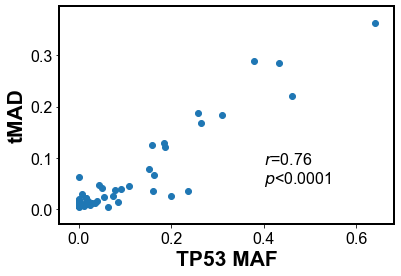

In [16]:
plt.scatter( bbb_df['MAF'], bbb_df['tMAD_noSZ_first'] )
r,p = spearmanr(bbb_df['MAF'], bbb_df['tMAD_noSZ_first'])
plt.xlabel('TP53 MAF')
plt.ylabel('tMAD')
plt.text(0.4,0.05,'$r$={:.2f}\n$p$<0.0001'.format(r,p))
plt.show()

0.33711442147225334 0.0037828143244503644


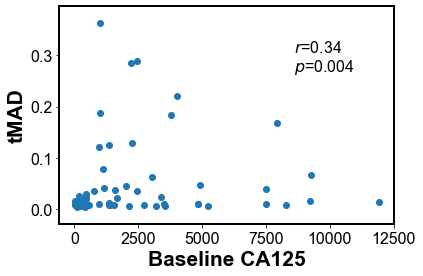

In [17]:
plt.scatter( bbb_df['CA125.closest_tx_start'], bbb_df['tMAD_noSZ_first'] )
r,p = spearmanr(bbb_df['CA125.closest_tx_start'], bbb_df['tMAD_noSZ_first'])
print(r,p)
plt.xlabel('Baseline CA125')
plt.ylabel('tMAD')
plt.text(0.7,0.7,'$r$={:.2f}\n$p$={:.3f}'.format(r,p), transform = plt.gca().transAxes)
plt.show()

0.317963925810991 0.006492368115140111


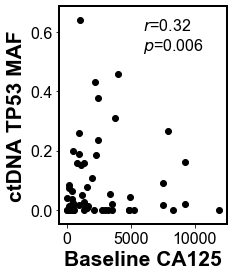

In [18]:
plt.figure(figsize=(3,4))
plt.scatter( bbb_df['CA125.closest_tx_start'], bbb_df['MAF'], c='k')
r,p = spearmanr(bbb_df['CA125.closest_tx_start'], bbb_df['MAF'])
print(r,p)
plt.xlabel('Baseline CA125')
plt.ylabel('ctDNA TP53 MAF')
plt.text(0.5,0.8,'$r$={:.2f}\n$p$={:.3f}'.format(r,p), transform = plt.gca().transAxes)
plt.show()

### BBB with others

All time points: 

In [19]:
rmat = df_corr.loc[['MAF','CA125.closest_tx_start'],['1-vol_1','9-vol_1','total_vol_1','LN_total_vol_1','n_lesions_v0_1',
                                              'recist_summed_diameter_scan1','Ascites_scan1', 'pleural_effusion_scan1',
                                             '1-vol_2','9-vol_2','total_vol_2','LN_total_vol_2','n_lesions_v0_2',
                                             'recist_summed_diameter_scan2','Ascites_scan2', 'pleural_effusion_scan2']]


In [20]:
pmat = asymmetric_pvalues(df, ['MAF','CA125.closest_tx_start'],['1-vol_1','9-vol_1','total_vol_1','LN_total_vol_1','n_lesions_v0_1',
                                              'recist_summed_diameter_scan1','Ascites_scan1', 'pleural_effusion_scan1',
                                             '1-vol_2','9-vol_2','total_vol_2','LN_total_vol_2','n_lesions_v0_2',
                                             'recist_summed_diameter_scan2','Ascites_scan2', 'pleural_effusion_scan2'])


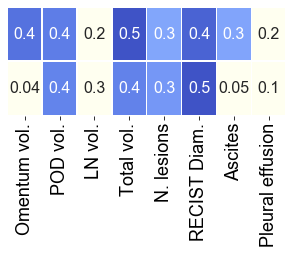

& 1-vol_1 & 9-vol_1 & LN_total_vol_1 & total_vol_1 & n_lesions_v0_1 & recist_summed_diameter_scan1 & Ascites_scan1 & pleural_effusion_scan1 \\
MAF & $r_S$ & 0.04 & 0.37 & 0.26 & 0.37 & 0.32 & 0.48 & 0.05 & 0.13 \\
& $p$ & 0.77 & 0.005 & 0.06 & 0.005 & 0.02 & 0.0003 & 0.77 & 0.36 \\
CA125.closest_tx_start & $r_S$ & 0.41 & 0.38 & 0.21 & 0.48 & 0.28 & 0.45 & 0.28 & 0.23 \\
& $p$ & 0.002 & 0.005 & 0.13 & 0.0003 & 0.04 & 0.0009 & 0.04 & 0.10 \\


In [21]:
tp1_vars = ['1-vol_1','9-vol_1','LN_total_vol_1','total_vol_1','n_lesions_v0_1',
            'recist_summed_diameter_scan1','Ascites_scan1', 'pleural_effusion_scan1']
fig = plt.figure(figsize=(5,2))
sns.heatmap(rmat[pmat<0.05][tp1_vars], cmap='coolwarm_r', linewidths=0.5, annot=True, vmin=-0.5, vmax=0.5, cbar_kws={"aspect":7}, fmt='.1g',cbar=False)
h = sns.heatmap(rmat[pmat>=0.05][tp1_vars], cmap=ListedColormap(['ivory']), linewidths=0.5, annot=True, cbar=False, fmt='.1g')
h.set_yticks([])
#h.set_yticklabels(['Baseline p53 MAF','Baseline CA125'], rotation=0, size=18)
h.set_xticklabels(['Omentum vol.', 'POD vol.', 'LN vol.', 'Total vol.', 'N. lesions', 'RECIST Diam.', 'Ascites', 'Pleural effusion'], size=18)

plt.ylim([0,2])
#plt.xlabel('Pre-treatment measurements')
plt.show()


# Print
for col in rmat[tp1_vars].columns.values:
        print('& {}'.format(col), end=' ')
print('\\\\')
for row in rmat.index.values:
    print('{}'.format(row), end=' ')
    print('& $r_S$', end=' ')
    for col in rmat[tp1_vars].columns.values: # print r
        print('& {:.2f}'.format(rmat.loc[row,col]), end=' ')
    print('\\\\')
    print('& $p$', end=' ')
    for col in rmat[tp1_vars].columns.values: # print p
        if pmat.loc[row,col]<0.001:
            print('& {:.4f}'.format(pmat.loc[row,col]), end=' ')
        elif pmat.loc[row,col]<0.01:
            print('& {:.3f}'.format(pmat.loc[row,col]), end=' ')
        else:
            print('& {:.2f}'.format(pmat.loc[row,col]), end=' ')
    print('\\\\')
    

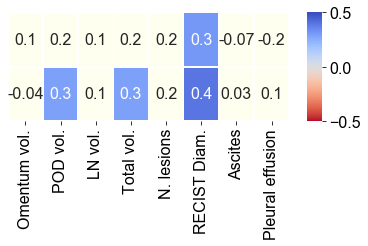

& 1-vol_2 & 9-vol_2 & LN_total_vol_2 & total_vol_2 & n_lesions_v0_2 & recist_summed_diameter_scan2 & Ascites_scan2 & pleural_effusion_scan2 \\
MAF & $r_S$ & -0.04 & 0.30 & 0.13 & 0.29 & 0.19 & 0.41 & 0.03 & 0.13 \\
& $p$ & 0.79 & 0.03 & 0.36 & 0.03 & 0.17 & 0.003 & 0.79 & 0.36 \\
CA125.closest_tx_start & $r_S$ & 0.10 & 0.23 & 0.10 & 0.22 & 0.20 & 0.32 & -0.07 & -0.16 \\
& $p$ & 0.50 & 0.10 & 0.50 & 0.11 & 0.15 & 0.02 & 0.63 & 0.24 \\


In [22]:
tp2_vars = ['1-vol_2','9-vol_2','LN_total_vol_2','total_vol_2','n_lesions_v0_2',
            'recist_summed_diameter_scan2','Ascites_scan2', 'pleural_effusion_scan2']

plt.figure(figsize=(6.3,2))
sns.heatmap(rmat[pmat<0.05][tp2_vars], cmap='coolwarm_r', linewidths=0.5, annot=True, vmin=-0.5, vmax=0.5, fmt='.1g', cbar_kws={"aspect":7})
h = sns.heatmap(rmat[pmat>=0.05][tp2_vars], cmap=ListedColormap(['ivory']), linewidths=0.5, annot=True, cbar=False, fmt='.1g' )
h.set_yticks([])
#h.set_yticklabels(['Baseline p53 MAF','Baseline CA125'], rotation=0)
h.set_xticklabels(['Omentum vol.', 'POD vol.', 'LN vol.', 'Total vol.', 'N. lesions', 'RECIST Diam.', 'Ascites', 'Pleural effusion'])
plt.ylim([0,2])
#plt.xlabel('Post-treatment measurements')
plt.show()

# Print
for col in rmat[tp2_vars].columns.values:
        print('& {}'.format(col), end=' ')
print('\\\\')
for row in rmat.index.values:
    print('{}'.format(row), end=' ')
    print('& $r_S$', end=' ')
    for col in rmat[tp2_vars].columns.values: # print r
        print('& {:.2f}'.format(rmat.loc[row,col]), end=' ')
    print('\\\\')
    print('& $p$', end=' ')
    for col in rmat[tp2_vars].columns.values: # print p
        if pmat.loc[row,col]<0.001:
            print('& {:.4f}'.format(pmat.loc[row,col]), end=' ')
        elif pmat.loc[row,col]<0.01:
            print('& {:.3f}'.format(pmat.loc[row,col]), end=' ')
        else:
            print('& {:.2f}'.format(pmat.loc[row,col]), end=' ')
    print('\\\\')

### Response

In [23]:
rmat = df_corr.loc[['rel_vol_change', 'rel_recist_change'], ['MAF','CA125.closest_tx_start','1-vol_1',
                                            '9-vol_1','LN_total_vol_1','total_vol_1','n_lesions_v0_1',
                                            'recist_summed_diameter_scan1','Ascites_scan1', 
                                            'pleural_effusion_scan1']]


In [24]:
pmat = asymmetric_pvalues(df, ['rel_vol_change', 'rel_recist_change'], ['MAF','CA125.closest_tx_start',
                                            '1-vol_1','9-vol_1','LN_total_vol_1','total_vol_1','n_lesions_v0_1',
                                            'recist_summed_diameter_scan1','Ascites_scan1', 
                                            'pleural_effusion_scan1'])

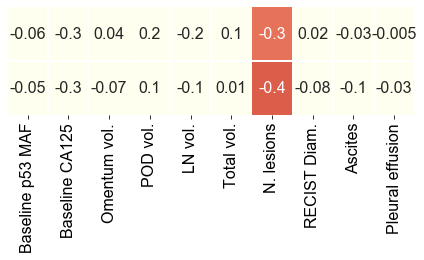

                        MAF  CA125.closest_tx_start   1-vol_1   9-vol_1  \
rel_vol_change     0.932008                0.066876  0.903772  0.623724   
rel_recist_change  0.932008                0.084932  0.932008  0.163788   

                   LN_total_vol_1  total_vol_1  n_lesions_v0_1  \
rel_vol_change           0.600866     0.959380        0.018950   
rel_recist_change        0.546578     0.546578        0.037219   

                   recist_summed_diameter_scan1  Ascites_scan1  \
rel_vol_change                         0.903772       0.546578   
rel_recist_change                      0.934299       0.932008   

                   pleural_effusion_scan1  
rel_vol_change                   0.932008  
rel_recist_change                0.964271  
& MAF & CA125.closest_tx_start & 1-vol_1 & 9-vol_1 & LN_total_vol_1 & total_vol_1 & n_lesions_v0_1 & recist_summed_diameter_scan1 & Ascites_scan1 & pleural_effusion_scan1 \\
rel_vol_change & -0.05 & -0.30 & -0.07 & 0.12 & -0.13 & 0.01 & -0.38 &

In [25]:
tp1_vars = ['MAF','CA125.closest_tx_start','1-vol_1','9-vol_1','LN_total_vol_1','total_vol_1','n_lesions_v0_1',
                                              'recist_summed_diameter_scan1','Ascites_scan1', 'pleural_effusion_scan1']

plt.figure(figsize=(7.3,2))
sns.heatmap(rmat[pmat<0.05][tp1_vars], cmap='coolwarm_r', linewidths=0.5, annot=True, vmin=-0.5, vmax=0.5,  cbar_kws={"aspect":7}, fmt='.1g', cbar=False)
h = sns.heatmap(rmat[pmat>=0.05][tp1_vars], cmap=ListedColormap(['ivory']), linewidths=0.5, annot=True, cbar=False, fmt='.1g')
h.set_yticks([])
#h.set_yticklabels(['% change total volume', '% change RECIST diam.'], rotation=0)
h.set_xticklabels(['Baseline p53 MAF','Baseline CA125','Omentum vol.', 'POD vol.', 'LN vol.', 'Total vol.', 'N. lesions', 'RECIST Diam.', 'Ascites', 'Pleural effusion'])
#plt.yticks([0.5,1.5], ['p53 MAF','Baseline CA125'],rotation=90)
#plt.yticks(rotation=0)
plt.ylim([0,2])
#plt.xlabel('Pre-treatment measurements')
plt.show()

print(pmat[tp1_vars])

# Print
for col in rmat[tp1_vars].columns.values:
        print('& {}'.format(col), end=' ')
print('\\\\')
for row in rmat.index.values:
    print('{}'.format(row), end=' ')
    for col in rmat[tp1_vars].columns.values: 
        print('& {:.2f}'.format(rmat.loc[row,col]), end=' ')
    print('\\\\')
    for col in rmat[tp1_vars].columns.values: 
        print('& {:.2f}'.format(pmat.loc[row,col]), end=' ')
    print('\\\\')

## Volume summaries

In [26]:
ln_vol = np.concatenate( (df['15-vol_1'], df['16-vol_1'], df['17-vol_1']) )
ln_vol = np.log(ln_vol[np.nonzero(ln_vol)])

ln_abd_vol = np.concatenate( (df['13-vol_1'], df['14-vol_1']) )
ln_abd_vol = np.log(ln_abd_vol[np.nonzero(ln_abd_vol)])

quad_vol = np.concatenate( (df['2-vol_1'], df['3-vol_1']) )
quad_vol = np.log(quad_vol[np.nonzero(quad_vol)])

pme_vol = np.concatenate( (df['4-vol_1'],df['5-vol_1'],df['6-vol_1'],df['7-vol_1']) )
pme_vol = np.log(pme_vol[np.nonzero(pme_vol)])

om_vol = df['1-vol_1'].values
om_vol = np.log(om_vol[np.nonzero(om_vol)])

pod_vol = df['9-vol_1'].values
pod_vol = np.log(pod_vol[np.nonzero(pod_vol)])

mets_vol = df['0-vol_1'].values

vol_categs = np.array([ln_vol, pme_vol, ln_abd_vol, quad_vol, om_vol, pod_vol])

categ_names = np.array(['Extraabdominal LNs', 'Abdominal LNs', 'Upper abdominal quad.', 'Paracolic, mesenteric,\nepigastric', 'Omentum', 'Ovaries and pelvis'])


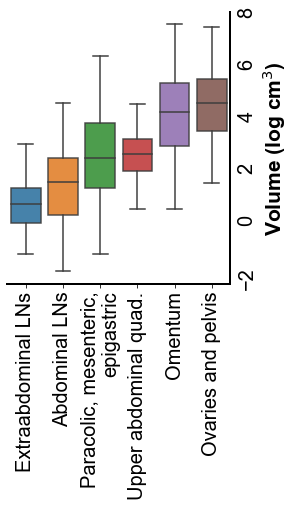

In [27]:
order = np.argsort([np.mean(x) for x in vol_categs])

f, ax = plt.subplots(figsize=(4,5))
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
sns.boxplot(data=vol_categs[order], fliersize=0, boxprops=dict(alpha=.9))
#sns.stripplot(data=vol_categs[order], color='0.25')
plt.yticks(size=20, rotation=90)
plt.xticks(range(len(vol_categs)), categ_names[order], rotation=90, size=20, multialignment='right')
plt.ylabel('Volume (log cm$^3$)')

sns.despine(left=True, right=False)

plt.show()

In [28]:
ln_num = df[(df['15-vol_1']>0) | (df['16-vol_1']>0) | (df['17-vol_1']>0)].shape[0]
ln_abd_num = df[(df['13-vol_1']>0) | (df['14-vol_1']>0)].shape[0]
quad_num = df[(df['2-vol_1']>0) | (df['3-vol_1']>0)].shape[0]
pme_num = df[(df['4-vol_1']>0) | (df['5-vol_1']>0) | (df['6-vol_1']>0) | (df['7-vol_1']>0)].shape[0]
om_num = df['1-vol_1'].shape[0]
pod_num = df['9-vol_1'].shape[0]
mets_num = df['0-vol_1'].shape[0]

num_categs = np.array([ln_num, pme_num, ln_abd_num, quad_num, om_num, pod_num])

In [29]:
#import matplotlib
#set3 = matplotlib.cm.get_cmap('Set3')
#colors = [set3(x) for x in range(6)]

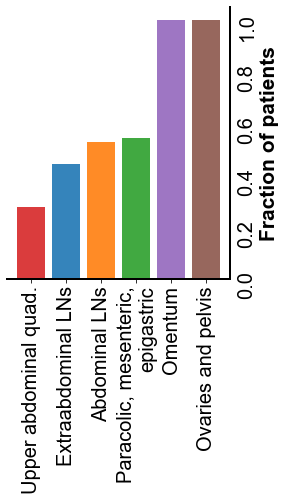

In [30]:
f, ax = plt.subplots(figsize=(4,5))
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
order = np.argsort(num_categs)
colors = ['C3','C0','C1','C2','C4','C5']
plt.bar(x=range(len(num_categs)), height=num_categs[order]/df.shape[0], color=colors, alpha=0.9)
plt.xticks(range(len(num_categs)), categ_names[order], rotation=90, size=20, multialignment='right')
plt.yticks(size=20,rotation=90)
plt.ylabel('Fraction of patients')

sns.despine(left=True, right=False)

plt.show()

## Volume change vs. site

In [31]:
om_vol_change = df['1-vol_2'].values/df['1-vol_1'].values
df['om_vol_change'] = om_vol_change
om_vol_change = om_vol_change[~np.isnan(om_vol_change)]

pod_vol_change = df['9-vol_2'].values/df['9-vol_1'].values
df['pod_vol_change'] = pod_vol_change
pod_vol_change = pod_vol_change[~np.isnan(pod_vol_change)]

vol_changes = [om_vol_change, pod_vol_change]

/Users/crispi01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/crispi01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [32]:
from scipy.stats import mannwhitneyu
_, p = mannwhitneyu(om_vol_change, pod_vol_change)
print(p)

6.079011832936045e-05


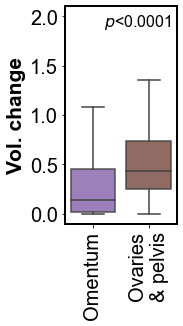

In [33]:
plt.figure(figsize=(2,4))
sns.boxplot(data=vol_changes, fliersize=0, palette={0:'C4', 1:'C5'}, boxprops=dict(alpha=.9))
#sns.stripplot(data=vol_changes, color='0.25')
plt.ylim([-0.1,2.1])
plt.yticks(size=20)
plt.xticks([0,1],['Omentum','Ovaries\n& pelvis'],rotation=90,size=20)
plt.ylabel('Vol. change',fontweight='bold')
if p<0.0001:
    plt.text(0.2, 1.9, '$p$<0.0001')
else:
    plt.text(0.3, 1.9, '$p$={:.4d}'.format(p))
plt.show()

## RECIST

In [34]:
from scipy.stats import pointbiserialr

PointbiserialrResult(correlation=0.7884002096711001, pvalue=2.0267090405640665e-16)


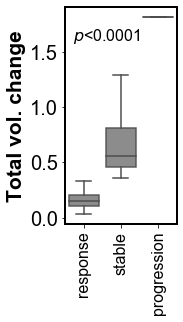

In [35]:
#_, p1 = mannwhitneyu(df.loc[df['response_volume']=='response','rel_vol_change'].values, df.loc[df['response_volume']=='stable','rel_vol_change'].values)
#_, p2 = mannwhitneyu(df.loc[df['response_volume']=='stable','rel_vol_change'].values, df.loc[df['response_volume']=='progression','rel_vol_change'].values)
#print(p1,p2)

df_pbs = df.copy()
df_pbs['recist_num'] = df_pbs['response_volume']
df_pbs['recist_num'].replace('response',1,inplace=True)
df_pbs['recist_num'].replace('stable',2,inplace=True)
df_pbs['recist_num'].replace('progression',3,inplace=True)
pbs = pointbiserialr(df_pbs['recist_num'], df_pbs['rel_vol_change'])
print(pbs)

plt.figure(figsize=(2,4))
sns.boxplot(data=df, x='response_volume', y='rel_vol_change', fliersize=0, boxprops=dict(alpha=.9), color='grey')
plt.yticks(size=20)
plt.xticks(rotation=90)
plt.ylabel('Total vol. change')
plt.xlabel('')

if pbs.pvalue<0.0001:
    plt.text(-0.3, 1.6, '$p$<0.0001')
else:
    plt.text(-0.3, 1.6, '$p$={:.2f}'.format(pbs.pvalue))

plt.show()

PointbiserialrResult(correlation=0.8017876078601605, pvalue=6.02852389281311e-16)


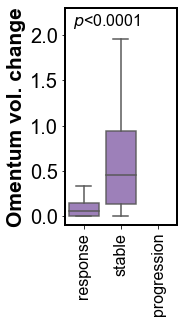

In [36]:
df_om = df[~np.isnan(df['om_vol_change'])]

df_pbs_om = df_om.copy()
df_pbs_om['recist_num'] = df_pbs_om['response_volume']
df_pbs_om['recist_num'].replace('response',1,inplace=True)
df_pbs_om['recist_num'].replace('stable',2,inplace=True)
df_pbs_om['recist_num'].replace('progression',3,inplace=True)
pbs = pointbiserialr(df_pbs_om['recist_num'], df_pbs_om['rel_vol_change'])
print(pbs)

plt.figure(figsize=(2,4))
sns.boxplot(data=df_om, x='response_volume', y='om_vol_change', fliersize=0, boxprops=dict(alpha=.9), color='C4')
plt.ylim([-0.1,2.3])
plt.yticks(size=20)
plt.xticks(rotation=90)
plt.ylabel('Omentum vol. change')
plt.xlabel('')

if pbs.pvalue<0.0001:
    plt.text(-0.3, 2.1, '$p$<0.0001')
else:
    plt.text(-0.3, 2.1, '$p$={:.2f}'.format(pbs.pvalue))


plt.show()

PointbiserialrResult(correlation=0.7949470142705198, pvalue=9.596260306586865e-16)


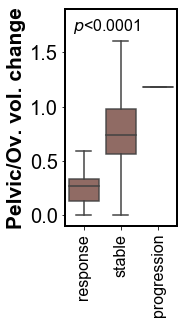

In [37]:
df_pod = df[~np.isnan(df['pod_vol_change'])]

df_pbs_pod = df_pod.copy()
df_pbs_pod['recist_num'] = df_pbs_pod['response_volume']
df_pbs_pod['recist_num'].replace('response',1,inplace=True)
df_pbs_pod['recist_num'].replace('stable',2,inplace=True)
df_pbs_pod['recist_num'].replace('progression',3,inplace=True)
pbs = pointbiserialr(df_pbs_pod['recist_num'], df_pbs_pod['rel_vol_change'])
print(pbs)

plt.figure(figsize=(2,4))
sns.boxplot(data=df_om, x='response_volume', y='pod_vol_change', fliersize=0, boxprops=dict(alpha=.9), color='C5')
plt.ylim([-0.1,1.9])
plt.yticks(size=20)
plt.xticks(rotation=90)
#plt.xticks([0,1],['Omentum','Ovaries\n& pelvis'],rotation=0,size=20)
plt.ylabel('Pelvic/Ov. vol. change')
plt.xlabel('')

if pbs.pvalue<0.0001:
    plt.text(-0.3, 1.7, '$p$<0.0001')
else:
    plt.text(-0.3, 1.7, '$p$={:.2f}'.format(pbs.pvalue))


plt.show()

## BRCA

In [38]:
df_marika = pd.read_csv('../data/neov-brca-survival.csv')

In [39]:
diff_cols = [x for x in df_marika.columns.values if x not in df.columns.values]
full_df = pd.merge(df, df_marika[diff_cols], how='inner', left_on='id', right_on='ID')

In [40]:
from scipy.stats import kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind

In [41]:
full_df['BRCA_grouped'].replace('HRD','BRCA_mut',inplace=True)
full_df['BRCA_grouped'].replace('VUS','BRCA_mut',inplace=True)

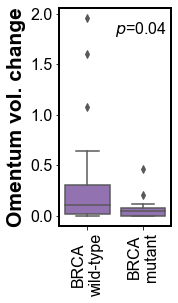

In [42]:
safe = (~full_df['BRCA_grouped'].isnull().values) & (~full_df['om_rel_change'].isnull().values)
safe_df = full_df[safe].copy()
brca_grouped_ind = pd.factorize(safe_df.loc[:,'BRCA_grouped'])[0]

_, p = mannwhitneyu(safe_df.loc[brca_grouped_ind==0,'om_rel_change'].values, safe_df.loc[brca_grouped_ind==1,'om_rel_change'].values)

plt.figure(figsize=(2,4))
sns.boxplot(data=safe_df, x='BRCA_grouped', y='om_rel_change', color='C4')
plt.xlabel('')
plt.xticks([0,1],['BRCA\nwild-type','BRCA\nmutant'],rotation=90)
plt.ylabel('Omentum vol. change')
plt.text(0.5, 1.8, '$p$={:.2f}'.format(p))
plt.show()

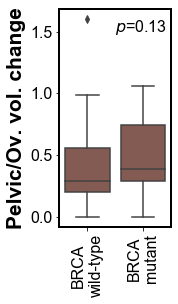

In [43]:
safe = (~full_df['BRCA_grouped'].isnull().values) & (~full_df['pod_rel_change'].isnull().values)
safe_df = full_df[safe].copy()
brca_grouped_ind = pd.factorize(safe_df.loc[:,'BRCA_grouped'])[0]

_, p = mannwhitneyu(safe_df.loc[brca_grouped_ind==0,'pod_rel_change'].values, safe_df.loc[brca_grouped_ind==1,'pod_rel_change'].values)

plt.figure(figsize=(2,4))
sns.boxplot(data=safe_df, x='BRCA_grouped', y='pod_rel_change', color='C5')
plt.xlabel('')
plt.xticks([0,1],['BRCA\nwild-type','BRCA\nmutant'],rotation=90)
plt.ylabel('Pelvic/Ov. vol. change')
plt.text(0.5, 1.5, '$p$={:.2f}'.format(p))
plt.show()

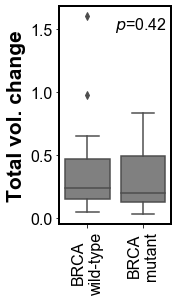

In [44]:
safe = (~full_df['BRCA_grouped'].isnull().values) & (~full_df['rel_vol_change'].isnull().values)
safe_df = full_df[safe].copy()
brca_grouped_ind = pd.factorize(safe_df.loc[:,'BRCA_grouped'])[0]

_, p = mannwhitneyu(safe_df.loc[brca_grouped_ind==0,'rel_vol_change'].values, safe_df.loc[brca_grouped_ind==1,'rel_vol_change'].values)

plt.figure(figsize=(2,4))
sns.boxplot(data=safe_df, x='BRCA_grouped', y='rel_vol_change', color='grey')
plt.xlabel('')
plt.xticks([0,1],['BRCA\nwild-type','BRCA\nmutant'],rotation=90)
plt.ylabel('Total vol. change',fontweight='bold')
plt.text(0.5, 1.5, '$p$={:.2f}'.format(p))
plt.show()